# Activity 11 - Ensemble Learning


***
##### CS 434 - Dating Mining and Machine Learning
##### Oregon State University-Cascades
***

# Load packages

In [0]:
import io
import time
import random
import textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# Dataset

The model evaluates cars according to the following concept structure:

CAR : car acceptability
* PRICE : overall price
  *  *buying* : buying price
  * *maint* : price of the maintenance
* TECH technical characteristics
  * COMFORT comfort
    * *doors* : number of doors
    * *persons* : capacity in terms of persons to carry
    * *lug_boot* : the size of luggage boot
  * *safety* : estimated safety of the car

Features:
* **buying** : v-high, high, med, low
* **maint** : v-high, high, med, low
* **doors** : 2, 3, 4, 5-more
* **persons** : 2, 4, more
* **lug_boot** : small, med, big
* **safety** : low, med, high


Class label:
* **evaluation**

class   |   N    |       N[%]
---     | ---    | ---
unacc   |  1210  |   (70.023 %) 
acc     |   384  |   (22.222 %) 
good    |    69  |   ( 3.993 %) 
v-good  |    65  |   ( 3.762 %) 


In [0]:
url='https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
attributes = ['buying','maint','doors','persons','lug_boot','safety','evaluation']

*** 
# Exercise #1 - Load data
*** 

##### 1.1 Read the `dat_file` into new dataframe `df`.
* `index_col=False`

In [4]:
# read the dataframe
df = pd.read_csv(url, index_col= False, names= attributes)
df

,buying,maint,doors,persons,lug_boot,safety,evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


##### 1.2 Describe dataframe

In [5]:
# describe df
df.describe()

,buying,maint,doors,persons,lug_boot,safety,evaluation
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,5more,more,med,med,unacc
freq,432,432,432,576,576,576,1210


##### 1.3 Display `info()` on `df`

In [6]:
# print df info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   buying      1728 non-null   object
 1   maint       1728 non-null   object
 2   doors       1728 non-null   object
 3   persons     1728 non-null   object
 4   lug_boot    1728 non-null   object
 5   safety      1728 non-null   object
 6   evaluation  1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


> Pay attention to the types of the values of our columns.

##### 1.4 Count values for `'evaluation'`

In [7]:
# value counts for 'evaluation'
df['evaluation'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: evaluation, dtype: int64

*** 
# Exercise #2 - Prepare dataset
*** 

2.1 Encode categorical labels

In [0]:
# encode labels
df = df.apply(LabelEncoder().fit_transform)

##### 2.2 Split `X` and `y`

In [0]:
# split X and y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

##### 2.3 Partition to train and test sets with hold-out

* test proportion of 10%
* `random_state=1`
* stratify by `y`

In [0]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1, stratify=y)

##### 2.4 Print the shapes of your four sets

In [11]:
# print shapes of train and test
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1555, 6) (173, 6) (1555,) (173,)


###### Self Check

In [0]:
assert X_train.shape[0] == 1555 and X_train.shape[1] == 6

*** 
# Exercise #3 - Build classifiers
*** 

##### 3.1 Function to `display_result`

1. Print the classifier name
1. Print the accuracy
1. Print the $F_1$ score
1. Graph the confusion matrix
1. Print a blank line (for spacing)

In [0]:
# function to display results
def display_result(y_test, y_pred, clf_label):
  #classifier name
  print(clf_label)
  #accuracy
  print(accuracy_score(y_test, y_pred))
  #f1
  print(f1_score(y_test, y_pred, average='weighted'))
  # graph a confusion matrix
  confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  fig, ax = plt.subplots(figsize=(2.5, 2.5))
  ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.tight_layout()
  plt.show()
  print(' \n')

##### 3.2 Define four weak classifiers

* `clf1` : Logistic regressor
  * penalty of `l2`
  * `C = 0.1`
  * solver of `lbfgs`
  * `random_state=1`
* `clf2` : Support vector machine `SVC`
  * `linear` kernel
  * `probability=True`
  * `random_state=1`
* `clf3` : $k$-nearest neighbor classifier
  * $k=1$
  * Manhattan distance
* `clf4` : Decision tree classifier
  * max depth of 1
  * `'entropty'`
  * `random_state=1`

In [0]:
# define classifiers 
clf1 = LogisticRegression(penalty='l2', 
                          C=0.1,
                          solver='lbfgs',
                          random_state=1)

clf2 = SVC(kernel='linear', probability=True, random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
clf4 = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)

###### Self Check

In [15]:
print(clf1)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



```
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
```                          

##### 3.3 Define three pipelines

Three out of the above four classifiers require features on the same scale.
  * *Which three classifiers require standardizing?*
  * *Which classifier does not?*

Define three pipelines for the three classifiers. Each has two steps:
 1. Standardize
 2. Classifier

In [0]:
# define pipelines
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf2]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

##### 3.4 Define list of classifier labels (provided)

In [0]:
# list of names of the classifiers
clf_labels = ['Logistic regression (LR)', 'Support vector machine (SVC)', 'K-Nearest neighbor (KNN)', 'Decision tree (DT)']

##### 3.5 Define list of classifiers

Define a list of classifier *or* pipeline variables
* match the order given in `clf_labels`
* three will be pipelines from `4.2`
* one will be a classifier from `4.1`

In [0]:
# list of classifiers (or pipelines)
clf_lst = [pipe1, pipe2, pipe3, clf4]


###### Self Check

In [0]:
assert len(clf_labels)==4 and len(clf_lst)==4

*** 
# Exercise #4 - Run experiments
*** 

##### 4.1 Run each classifier

Iterate over classifiers and for each:
1. Train the `clf` on the training set
2. Predict the test set and save predictions
3. Call your `display_result` function

Logistic regression (LR)
0.6878612716763006
0.6303298197891873


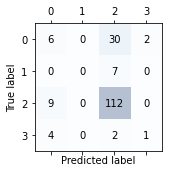

 

Support vector machine (SVC)
0.7283236994219653
0.6459741105593096


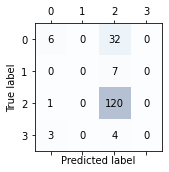

 

K-Nearest neighbor (KNN)
0.7456647398843931
0.7680945766306702


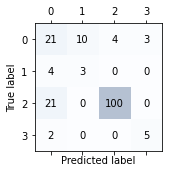

 

Decision tree (DT)
0.6994219653179191
0.5757146789351579


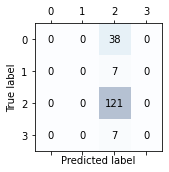

In [20]:
# run each classifier
for clf, label in zip(clf_lst, clf_labels):
 clf.fit(X_train, y_train)
 y_pred = clf.predict(X_test)
 display_result(y_test, y_pred, label)


###### Self Check

Results for first classifier:
```
Logistic regression (LR)
  accuracy: 0.688
  F1 score: 0.630
```

###### Iteration hint (*code spoiler*)

`for clf, label in zip(clf_lst, clf_labels):`

##### 4.2 Define a Voting Classifier (Hard)

* construct a Voting classifier: [(see api)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
* use `'hard'` voting
* use the classifiers (or pipelines) from `4.1`
* train, test, and `display_results`

Voting Classifier - Hard
0.7225433526011561
0.6451195014963309


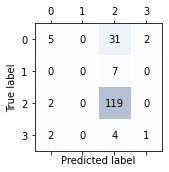

In [33]:
# ensemble classifer (hard)
hard_vclf = VotingClassifier(estimators=[(clf_labels[0], clf_lst[0]),
                                         (clf_labels[1], clf_lst[1]),
                                         (clf_labels[2], clf_lst[2]),
                                         (clf_labels[3], clf_lst[3]),],
                             voting='hard')

hard_vclf.fit(X_train, y_train)
y_pred = hard_vclf.predict(X_test)
display_result(y_test, y_pred, 'Voting Classifier - Hard')

##### 4.3 Define a Voting Classifier (Soft)

* construct a [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
* use `'soft'` voting
* use the classifiers (or pipelines) from `4.1`
* train, test, and `display_results`

Voting Classifier - Hard
0.7225433526011561
0.6698508851314773


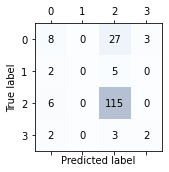

In [35]:
# ensemble classifer (soft)
hard_vclf = VotingClassifier(estimators=[(clf_labels[0], clf_lst[0]),
                                         (clf_labels[1], clf_lst[1]),
                                         (clf_labels[2], clf_lst[2]),
                                         (clf_labels[3], clf_lst[3]),],
                             voting='soft')

hard_vclf.fit(X_train, y_train)
y_pred = hard_vclf.predict(X_test)
display_result(y_test, y_pred, 'Voting Classifier - Hard')

*** 
# Exercise #5 - Random Forest
*** 

##### 5.1 Timing example (provided)

In [32]:
# timing examples
start = time.time()
print('hello room')   # hello world (2020 version)
end = time.time()
print('%.8f seconds elapsed' % ((end - start)))

hello room
0.00010967 seconds elapsed


##### 5.2 Random forest experiment (small)

* time your code
* use `n=10` trees
* `random_state=1`
* train, test, and `display_results`


small
0.9421965317919075
0.9416022351340639


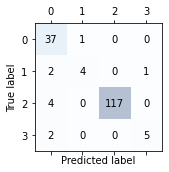

 

0.3605654239654541 sec


In [40]:
# define a random forest (10)
start = time.time()
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=10, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
display_result(y_test, y_pred, 'small')
end = time.time()
print(str(end - start) + ' sec')

##### 5.3 Random forest experiment (medium)

small
0.9826589595375722
0.9827595712756292


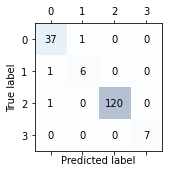

 

0.6868381500244141 sec


In [47]:
# define a random forest (100)
start = time.time()
forest_100 = RandomForestClassifier(criterion='gini',
                                n_estimators=100, 
                                random_state=1,
                                n_jobs=2)
forest_100.fit(X_train, y_train)
y_pred = forest.predict(X_test)
display_result(y_test, y_pred, 'small')
end = time.time()
print(str(end - start) + ' sec')

##### 5.4 Random forest experiment (large)

small
0.9826589595375722
0.9827595712756292


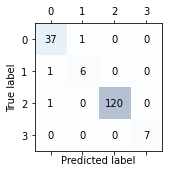

 

2.737525463104248 sec


In [42]:
# define a random forest (1000)
start = time.time()
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=1000, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
display_result(y_test, y_pred, 'small')
end = time.time()
print(str(end - start) + ' sec')

##### 5.5 Feature selection with random forest

* re-define (or re-use) the Random Forest from `5.3`
  * size `100`
  * `random_state=1`
* determine the importance of each feature
  * adapt the example from  `Lecture 04`

 1) safety                         0.290359
 2) persons                        0.221521
 3) buying                         0.183465
 4) maint                          0.158737
 5) lug_boot                       0.083053
 6) doors                          0.062864


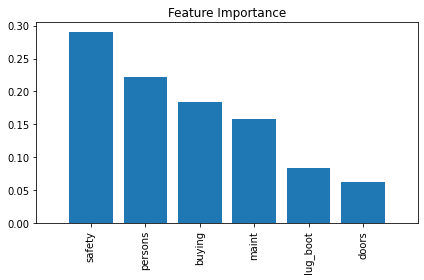

In [48]:
# determine feature importance
feat_labels = df.columns[:-1]
importances = forest_100.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

###### Self Check

> You shoud produce a bar chart of the six features, ranked.
>
> The importance of doors is `0.062864`.